# **AP157 Machine Learning Lab Assignment**
## Module A.3: Dimensionality Reduction -- Principal Component Analysis of SDSS Galaxy Spectra

_Instructions_: Answer each part of the assignment as completely as you can. Discuss **all** your code and results as clearly and concisely as possible.

_Scoring Criteria_: 50% - *correctness of code*; 50% - *discussion of the code and results*. Maximum score is **100 points** (Parts 1 and 2 are worth 25 and 75 points, respectively).

_Credits_: This assignment is based on the scikit-learn tutorial "Dimensionality Reduction of Astronomical Spectra" ([link](https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/astronomy/dimensionality_reduction.html))

### Student Information

_Full Name (Last Name, First Name)_: \
_Student No._:\
_Section_:

### Submission Information

_Date and Time Submitted (most recent upload)_:

**HONOR PLEDGE** I affirm that I have upheld the highest principles of honesty and integrity in my academic work and that this lab assignment is my own work.

**Sign here with your full name:**

### Grading Information (c/o Instructor)

TOTAL SCORE: **[]**/100

Score breakdown:
* Part 1 - []/25
* Part 2 - []/75

_Date and Time Scored (MM/DD/YYYY HH:MM AM/PM):_

Define the directory path to the location of the file, i.e. if it is in a
folder named "AP157" under My Drive, then the file path will be "/content/drive/My Drive/AP157". Change the string variable in the code cell below, as needed:

In [3]:
file_path = "..//datasets//"

Now, we can load the file using $\tt numpy$'s $\tt load$ function below.


In [11]:
import numpy as np
import pandas as pd

data = np.load(file_path + 'spec4000_corrected.npz')
data_pd = pd.DataFrame(data)
data_pd.head()

,0
0,spec_recons
1,wavelength


The NpzFile object is a dictionary-like object which can be queried for its list of arrays and the arrays themselves ([reference](https://numpy.org/doc/stable/reference/generated/numpy.savez.html)). Our object contains two arrays: ``spec_recons`` - 4000 reconstructed SDSS spectra each with 1000 attributes (flux in units of $10^{-17}$ erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$) and ``wavelength`` - array of wavelengths (in units of Angstroms) corresponding to these attributes.

In [5]:
data.files

['spec_recons', 'wavelength']

In [6]:
np.shape(data['spec_recons']), np.shape(data['wavelength'])

((4000, 1000), (1000,))

Let's plot the first few spectra to visualize our data

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Sample SDSS spectra')

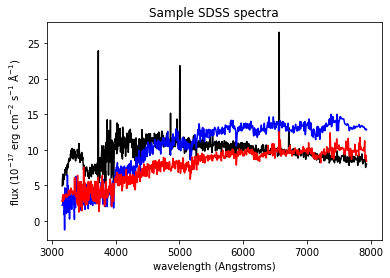

In [8]:
wavelength = data['wavelength']
flux0 = data['spec_recons'][0,:]
flux1 = data['spec_recons'][1,:]
flux2 = data['spec_recons'][2,:]

plt.plot(wavelength, flux0, 'k-')
plt.plot(wavelength, flux1, 'b-')
plt.plot(wavelength, flux2, 'r-')
plt.ylabel("flux ($10^{-17}$ erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$)")
plt.xlabel("wavelength (Angstroms)")
plt.title("Sample SDSS spectra")

#### PART 1 - Get mean normalized spectrum *(25 pts.)*

Plot the mean spectrum by first normalizing the spectra and plot the mean and standard deviation. For this, you may use the ``normalize`` function in scikit-learn's preprocessing module [(documentation)](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html). Describe the mean spectrum and note wavelengths with the highest variation across the sample. What is the reason for this variation?


In [55]:
norm_spectra.shape

(4000, 1000)

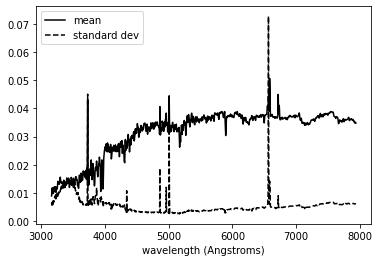

In [27]:
from sklearn.preprocessing import normalize

spectra = data['spec_recons']
norm_spectra = normalize(spectra, axis = 1)
plt.plot(wavelength, np.mean(norm_spectra, axis = 0), 'k-', label = 'mean')
plt.plot(wavelength, np.std(norm_spectra, axis = 0), 'k--', label = 'standard dev')
plt.xlabel("wavelength (Angstroms)")
plt.legend()

#### PART 2 - Get principal components *(75 pts.)*

Perform Principal Component Analysis (PCA) and visualize the top principal components:
1. Get the first 4 principal components using the ``PCA`` function in scikit-learn's decomposition module [(documentation)](https://scikit-learn.org/0.15/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA). Make sure to use the normalized spectra as input. *(25 pts.)*


In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca_spec = pca.fit_transform(norm_spectra)
print(pca_spec)
np.shape(pca_spec)

[[ 0.22971623  0.01853556  0.07517286 -0.01701601]
 [-0.11125737 -0.04167841 -0.02532055  0.00998553]
 [-0.02065165 -0.06298824  0.00405825  0.00734551]
 ...
 [ 0.1328535   0.06791987  0.10341398 -0.05075216]
 [-0.04773091 -0.03604382 -0.01644575 -0.01015836]
 [-0.02538429 -0.043906    0.02283248 -0.00113297]]


(4000, 4)

2. Plot the first two principal components (coefficient 1 in the x axis and coefficient 2 in the y axis). Make sure to label the axes and good to set x and y axis limits to be equal. *(25 pts.)*

Text(0, 0.5, 'Component 2')

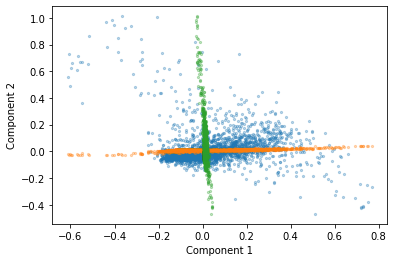

In [121]:
inv_pca = pca.inverse_transform(pca_spec)
plt.scatter(pca_spec[:,0],pca_spec[:,1], s = 5, alpha = 0.3)
plt.scatter(pca_spec[:,0],inv_pca[:,0], s = 5, alpha = 0.3)
plt.scatter(inv_pca[:,1],pca_spec[:,1], s = 5, alpha = 0.3)
plt.xlabel('Component 1')
plt.ylabel('Component 2')

3. Plot the first 4 eigenvectors together with the mean spectrum. Add an arbitrary y-offset between the spectra for clarity. *(25 pts.)*

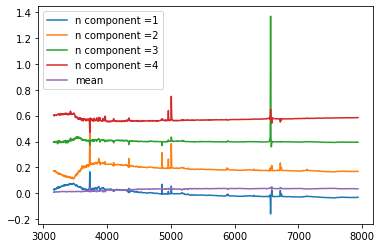

In [106]:
eigenvec = pca.components_
eigenval = pca.explained_variance_

for i in range(4):
    plt.plot(wavelength, eigenvec[i]+0.2*i, label = 'n component ='+str(i+1) )

    
plt.plot(wavelength, np.mean(norm_spectra, axis = 0), label = 'mean')
plt.legend()